In [112]:
import load_data

ds = load_data.LabeledDataset(root_dir=load_data.TRAINING_DATA_ROOT)



In [113]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

# https://pytorch.org/vision/stable/auto_examples/plot_repurposing_annotations.html#sphx-glr-auto-examples-plot-repurposing-annotations-py
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        

In [114]:
import torchvision

import importlib

index_to_class = load_data.load_inverted_class_index()

def show_with_bboxes(element):
    img, bboxes, class_idxs = element
    classes = [
        index_to_class[class_idx.item()] 
        for class_idx in class_idxs
    ]
    annotated = torchvision.utils.draw_bounding_boxes(img, bboxes, classes, colors='red')
    show(annotated)



In [115]:
class MergedDataset(torch.utils.data.Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        
    def __len__(self):
        return sum(map(len, self.datasets))
    
    def __getitem__(self, idx):
        for ds in self.datasets:
            print('try ', idx)
            if idx >= len(ds):
                idx -= len(ds)
            else:
                return ds[idx]
            
train_ds = load_data.LabeledDataset(root_dir=load_data.TRAINING_DATA_ROOT)
val_ds = load_data.LabeledDataset(root_dir=load_data.VALIDATION_DATA_ROOT)
            
            
merged = MergedDataset([train_ds, val_ds])



            

In [116]:
import pandas as pd

teacher_ap = pd.read_csv("data/analysis/teacher_AP.csv")
student_ap = pd.read_csv("data/analysis/student_AP.csv")

teacher_ap

Wall time    Step      Value
0   1.669651e+09    5999   0.000308
1   1.669657e+09   11999   0.000308
2   1.669662e+09   17999   0.000308
3   1.669667e+09   23999   0.000308
4   1.669673e+09   29999   0.000308
..           ...     ...        ...
75  1.670580e+09  413999  40.892864
76  1.670590e+09  419999  40.930660
77  1.670601e+09  425999  40.954857
78  1.670612e+09  431999  40.918674
79  1.670622e+09  437999  41.051994

[80 rows x 3 columns]

In [ ]:
from matplotlib import pyplot as plt

plt.plot(teacher_ap['Step'], teacher_ap['Value'])

In [ ]:
def remove_older_runs(df):
    latest = df.groupby(by='Step', sort=True).agg({
        'Step': 'max',
        'Wall time': 'max',
        'Value': 'idxmax'
    })
    latest['Value'] = df.loc[latest['Value'], 'Value'].values
    return latest

df =  remove_older_runs(teacher_ap)
plt.plot(df['Step'], df['Value'])

In [ ]:
teacher_ap_last = remove_older_runs(teacher_ap)
student_ap_last = remove_older_runs(student_ap)


In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=800)

plt.plot(teacher_ap_last['Step'], teacher_ap_last['Value'], label='Teacher AP')
plt.plot(student_ap_last['Step'], student_ap_last['Value'], label='Student AP')

plt.legend(loc='upper left')
plt.title('AP vs training steps (top-level metric)')
plt.ylabel('AP')
plt.xlabel('Steps')
plt.grid()

In [31]:

teacher_ap_nail = remove_older_runs(pd.read_csv("data/analysis/nail_ap_teacher.csv"))
student_ap_nail = remove_older_runs(pd.read_csv("data/analysis/nail_ap_student.csv"))

teacher_ap_dog = remove_older_runs(pd.read_csv("data/analysis/dog_ap_teacher.csv"))
student_ap_dog = remove_older_runs(pd.read_csv("data/analysis/dog_ap_student.csv"))


In [33]:
def do_plot(df, label):
    plt.plot(df['Step'], df['Value'], label=label)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=400)

do_plot(teacher_ap_nail, 'Teacher AP ("nail" class)')
do_plot(student_ap_nail, 'Student AP ("nail" class)')


do_plot(teacher_ap_dog, 'Teacher AP ("dog" class)')
do_plot(student_ap_dog, 'Student AP ("dog" class)')

plt.legend(loc='upper left')
plt.title('AP vs training steps (common vs uncommon classes)')
plt.ylabel('AP')
plt.xlabel('Steps')
plt.grid()

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=800)

teacher_ap_filter = teacher_ap_last.tail(10)
student_ap_filter = student_ap_last.tail(10)

do_plot(teacher_ap_filter, 'Teacher AP')
do_plot(student_ap_filter, 'Student AP')

plt.legend(loc='upper left')
plt.title('AP vs training steps (top-level metric, last 60k steps)')
plt.ylabel('AP')
plt.xlabel('Steps')
plt.grid()

In [117]:
from PIL import Image, ImageColor, ImageDraw, ImageFont
import torch 

def _generate_color_palette(num_objects: int):
    palette = torch.tensor([2**25 - 1, 2**15 - 1, 2**21 - 1])
    return [tuple((i * palette) % 255) for i in range(num_objects)]


def draw_bounding_boxes(
    image,
    boxes,
    labels=None,
    colors=None,
    fill=False,
    width = 1,
    font = None,
    font_size = None,
) -> torch.Tensor:

    """
    Draws bounding boxes on given image.
    The values of the input image should be uint8 between 0 and 255.
    If fill is True, Resulting Tensor should be saved as PNG image.

    Args:
        image (Tensor): Tensor of shape (C x H x W) and dtype uint8.
        boxes (Tensor): Tensor of size (N, 4) containing bounding boxes in (xmin, ymin, xmax, ymax) format. Note that
            the boxes are absolute coordinates with respect to the image. In other words: `0 <= xmin < xmax < W` and
            `0 <= ymin < ymax < H`.
        labels (List[str]): List containing the labels of bounding boxes.
        colors (color or list of colors, optional): List containing the colors
            of the boxes or single color for all boxes. The color can be represented as
            PIL strings e.g. "red" or "#FF00FF", or as RGB tuples e.g. ``(240, 10, 157)``.
            By default, random colors are generated for boxes.
        fill (bool): If `True` fills the bounding box with specified color.
        width (int): Width of bounding box.
        font (str): A filename containing a TrueType font. If the file is not found in this filename, the loader may
            also search in other directories, such as the `fonts/` directory on Windows or `/Library/Fonts/`,
            `/System/Library/Fonts/` and `~/Library/Fonts/` on macOS.
        font_size (int): The requested font size in points.

    Returns:
        img (Tensor[C, H, W]): Image Tensor of dtype uint8 with bounding boxes plotted.
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError(f"Tensor expected, got {type(image)}")
    elif image.dtype != torch.uint8:
        raise ValueError(f"Tensor uint8 expected, got {image.dtype}")
    elif image.dim() != 3:
        raise ValueError("Pass individual images, not batches")
    elif image.size(0) not in {1, 3}:
        raise ValueError("Only grayscale and RGB images are supported")
    elif (boxes[:, 0] > boxes[:, 2]).any() or (boxes[:, 1] > boxes[:, 3]).any():
        print('have boxes: ', boxes)
        raise ValueError(
            "Boxes need to be in (xmin, ymin, xmax, ymax) format. Use torchvision.ops.box_convert to convert them"
        )

    num_boxes = boxes.shape[0]

    if num_boxes == 0:
        print("boxes doesn't contain any box. No box was drawn")
        return image

    if labels is None:
        labels = [None] * num_boxes  # type: ignore[no-redef]
    elif len(labels) != num_boxes:
        raise ValueError(
            f"Number of boxes ({num_boxes}) and labels ({len(labels)}) mismatch. Please specify labels for each box."
        )

    if colors is None:
        colors = _generate_color_palette(num_boxes)
    elif isinstance(colors, list):
        if len(colors) < num_boxes:
            raise ValueError(f"Number of colors ({len(colors)}) is less than number of boxes ({num_boxes}). ")
    else:  # colors specifies a single color for all boxes
        colors = [colors] * num_boxes

    colors = [(ImageColor.getrgb(color) if isinstance(color, str) else color) for color in colors]

    if font is None:
        if font_size is not None:
            print("Argument 'font_size' will be ignored since 'font' is not set.")
        txt_font = ImageFont.load_default()
    else:
        txt_font = ImageFont.truetype(font=font, size=font_size or 10)

    # Handle Grayscale images
    if image.size(0) == 1:
        image = torch.tile(image, (3, 1, 1))

    ndarr = image.permute(1, 2, 0).cpu().numpy()
    img_to_draw = Image.fromarray(ndarr)
    img_boxes = boxes.to(torch.int64).tolist()

    if fill:
        draw = ImageDraw.Draw(img_to_draw, "RGBA")
    else:
        draw = ImageDraw.Draw(img_to_draw)
    
    PX_PER_LABEL = 10
    for idx, (bbox, color, label) in enumerate(zip(img_boxes, colors, labels)):  # type: ignore[arg-type]
        if fill:
            fill_color = color + (100,)
            draw.rectangle(bbox, width=width, outline=color, fill=fill_color)
        else:
            draw.rectangle(bbox, width=width, outline=color)

        if label is not None:
            margin = width + 1
            draw.text((0, PX_PER_LABEL * idx), label, fill=color, font=txt_font)

        #if label is not None:
        #    margin = width + 1
        #    draw.text((bbox[0] + margin, bbox[1] + margin), label, fill=color, font=txt_font)

    return torch.from_numpy(np.array(img_to_draw)).permute(2, 0, 1).to(dtype=torch.uint8)


In [118]:
import json

results_434k = json.load(open('data/analysis/coco_instances_results_0434999.json', 'r'))
#results_175k = json.load(open('data/analysis/coco_instances_results_174999.json', 'r'))
results_101k = json.load(open('data/analysis/coco_instances_results_0109999.json', 'r'))

In [119]:
import load_data

val_ds = load_data.LabeledDataset(root_dir=load_data.VALIDATION_DATA_ROOT)


In [120]:
def collect_image_ids(results):
    return {
        result['image_id'] 
        for result in results
    }



In [121]:
imgs_101k = collect_image_ids(results_101k)
print(len(imgs_101k))
imgs_434k = collect_image_ids(results_434k)
print(len(imgs_434k))

imgs_all = imgs_101k & imgs_434k


19997
19997


In [122]:
have_imgs = list(sorted(imgs_all))

In [123]:
cur = 0

In [124]:
WANT = [27, 38, 53]
NAMED = [
    ('101k', results_101k),
   # ('175k', results_175k),
    ('434k', results_434k),
]

In [125]:
index_to_class = load_data.load_inverted_class_index()

def show_with_bboxes(element, color='green'):
    img, bboxes, class_idxs = element
    classes = [
        index_to_class[class_idx.item()] 
        for class_idx in class_idxs
    ]
    annotated = torchvision.utils.draw_bounding_boxes(img, bboxes, classes, colors=color)
    show(annotated)

el:  1


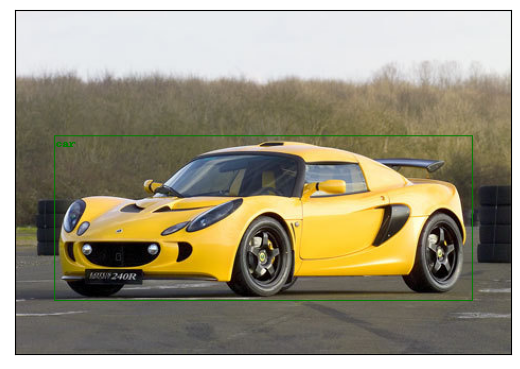

In [126]:
cur += 1
print('el: ', cur)
show_with_bboxes(val_ds[have_imgs[cur]])

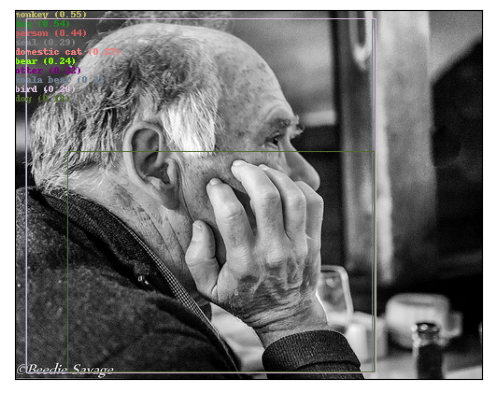

In [127]:
import PIL 
import torchvision 
import random 

def filter_results_for(idx, results):
    return [
        result for result in results
        if result['image_id'] == idx
    ]

random.seed(0)
ALL_COLORS = list(PIL.ImageColor.colormap.keys())
random.shuffle(ALL_COLORS)

#def _generate_color_palette(num_objects: int):
#    palette = torch.tensor([2**25 - 1, 2**15 - 1, 2**21 - 1])
#    return [tuple((i * palette) % 255) for i in range(num_objects)]

def _generate_color_palette(num_objects: int):
    #return [tuple((i * palette) % 255) for i in range(num_objects)]
    return ALL_COLORS[:num_objects]


def show_with_bboxes_inference(idx, ds, results, color=None, font_size=10, topn=5):

    have_results = filter_results_for(idx, results)[:topn]
    if color is None:
        color = _generate_color_palette(len(have_results))
    img, _, _ = ds[idx]
    class_idxs = [r['category_id'] for r in have_results]
    bboxes = torchvision.ops.box_convert(torch.tensor([
        r['bbox'] for r in have_results
    ]), in_fmt='xywh', out_fmt='xyxy')
    classes = [
        f'{index_to_class[r["category_id"]]} ({r["score"]:.2f})'
        for r in have_results
    ]
    annotated = draw_bounding_boxes(img, bboxes, classes, colors=color)
    show(annotated)
    
show_with_bboxes_inference(2, val_ds, results, color=None, topn=10)



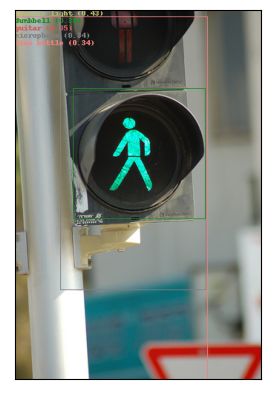

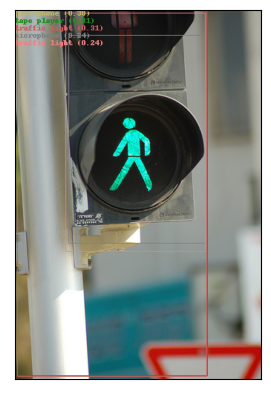

In [74]:
show_with_bboxes_inference(have_imgs[WANT[0]], val_ds, results_101k)
show_with_bboxes_inference(have_imgs[WANT[0]], val_ds, results_434k)

In [32]:
cur_idx = 0

In [51]:
GOOD_IMGS = [-1, 17, 23, 35]
cur_idx

3

35
ground truth
inference at  101k
inference at  434k


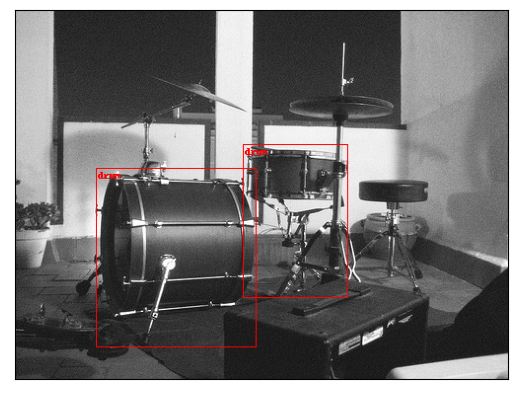

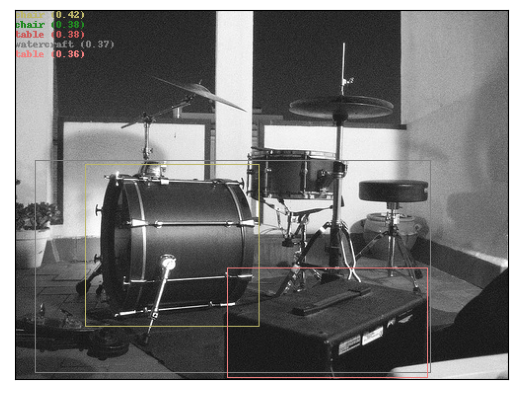

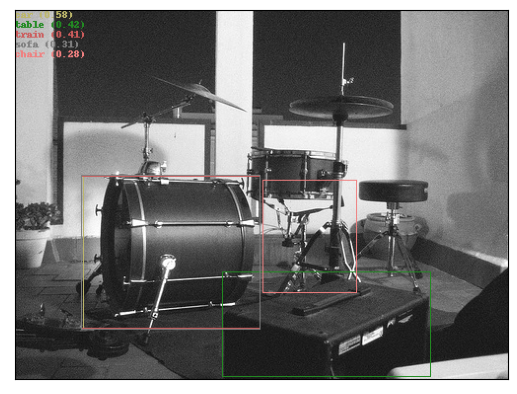

In [111]:
print(cur_idx)
cur_idx += 1
idx = have_imgs[cur_idx]
print('ground truth')
show_with_bboxes(val_ds[idx], color='red')
for name, results in NAMED:
    print('inference at ', name)
    try:
        show_with_bboxes_inference(idx, val_ds, results, color=None, topn=5)
    except Exception as e:
        print('Error: ', e)
        pass
     

ground truth
inference at  101k
inference at  434k
ground truth
inference at  101k
inference at  434k
ground truth
inference at  101k
inference at  434k


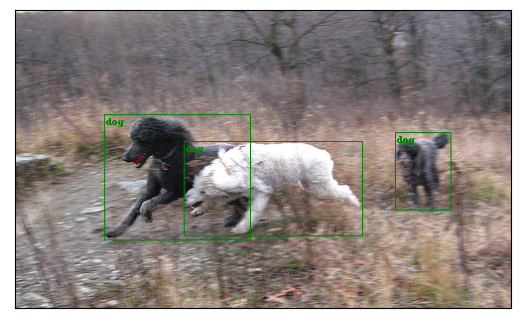

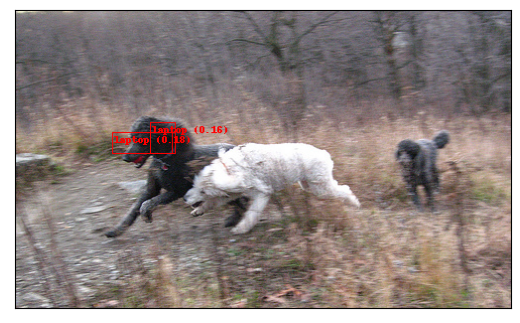

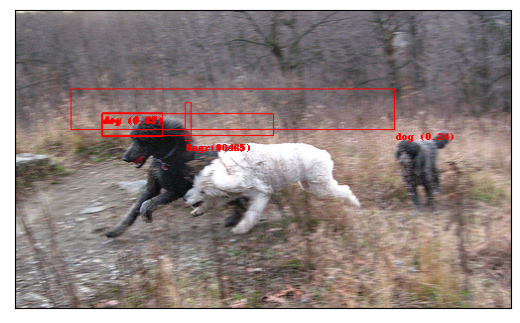

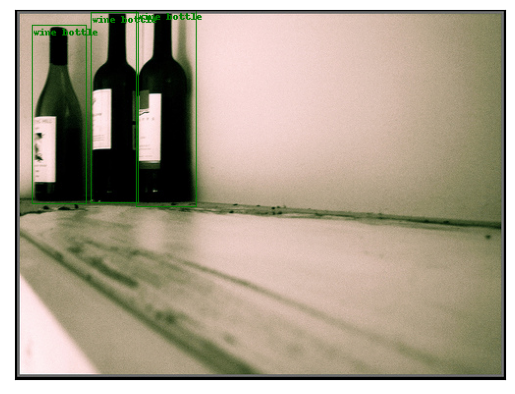

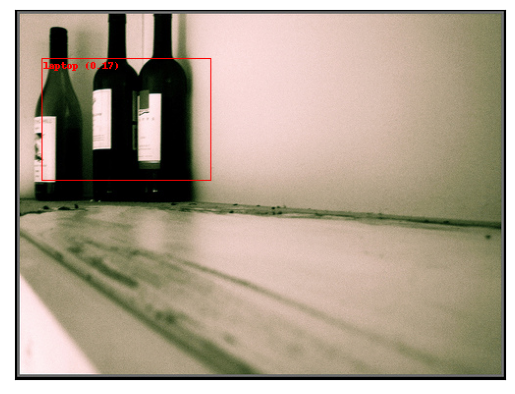

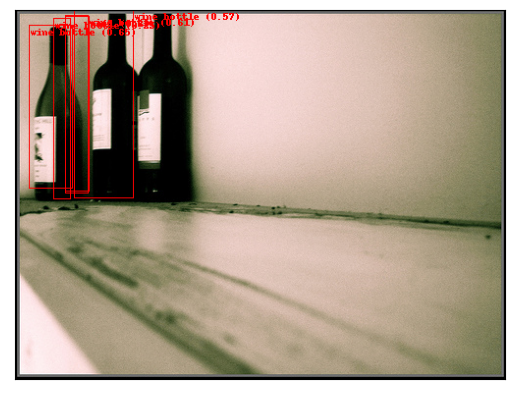

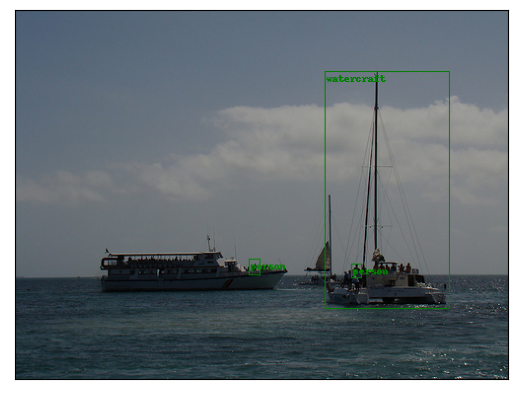

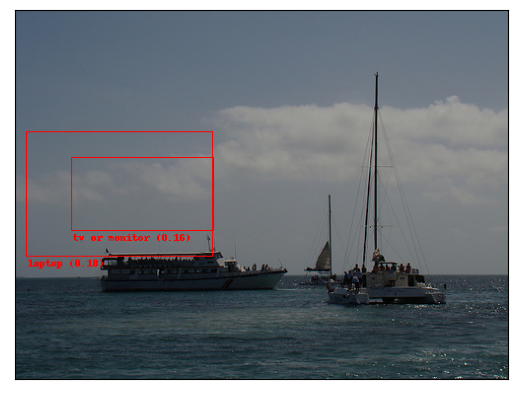

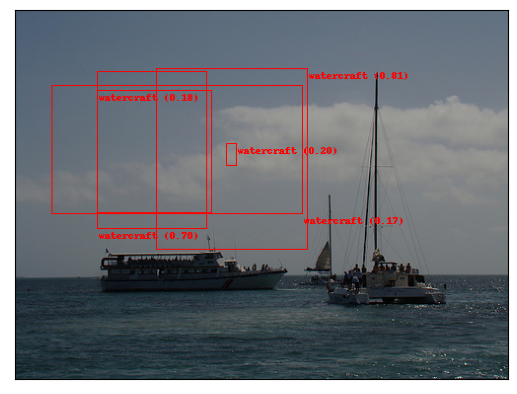

In [205]:
for idx in WANT:
    idx = have_imgs[idx]
    print('ground truth')
    show_with_bboxes(val_ds[idx])
    for name, results in NAMED:
        print('inference at ', name)
        show_with_bboxes_inference(idx, val_ds, results)
        
        